# Estrategia Básica: cruce de medias móviles
El notebook busca analizar todas las combinaciones de cruces de medias móviles para analziar cuales serían rentables, observar si hay similitudes entre las distintas combinaciones y obtener gráficas representativas.

In [1]:
# agrando a toda la pantalla el notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## La idea es generar un iterador sobre combinaciones de MA's de corto y alrgo plazo con Stop Loss fijo al -2%

In [2]:
import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
%matplotlib inline

## Get data binance API

In [3]:
market = 'BTCUSDT'
tick_interval = '4h'
limit = 1000  #1000 es el maximo de la api
url_prices = 'https://api.binance.com/api/v1/klines?symbol='+market+'&interval='+tick_interval+'&limit='+str(limit)
init_candles = requests.get(url_prices).json()

In [4]:
df = pd.DataFrame(columns=['open_time','open', 'high', 'low','close','volume','close_time','quote','trades','takers_buy_base','takers_buy_quote','ignore'])
for i in range(len(init_candles)):
    df.loc[i] = init_candles[i]
df=df.drop(['ignore'],axis=1)
df = df.astype(float)

In [5]:
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df['close_time'] = df['close_time'].dt.tz_localize('utc').dt.tz_convert('Europe/Madrid')
#df = df.set_index('close_time')

In [6]:
original_df = df.copy(deep=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype                        
---  ------            --------------  -----                        
 0   open_time         1000 non-null   float64                      
 1   open              1000 non-null   float64                      
 2   high              1000 non-null   float64                      
 3   low               1000 non-null   float64                      
 4   close             1000 non-null   float64                      
 5   volume            1000 non-null   float64                      
 6   close_time        1000 non-null   datetime64[ns, Europe/Madrid]
 7   quote             1000 non-null   float64                      
 8   trades            1000 non-null   float64                      
 9   takers_buy_base   1000 non-null   float64                      
 10  takers_buy_quote  1000 non-null   float64                    

In [8]:
time_col = 'close_time'
time = df.iloc[-1][time_col] - df.iloc[0][time_col]
time.total_seconds()/60/60

4000.0

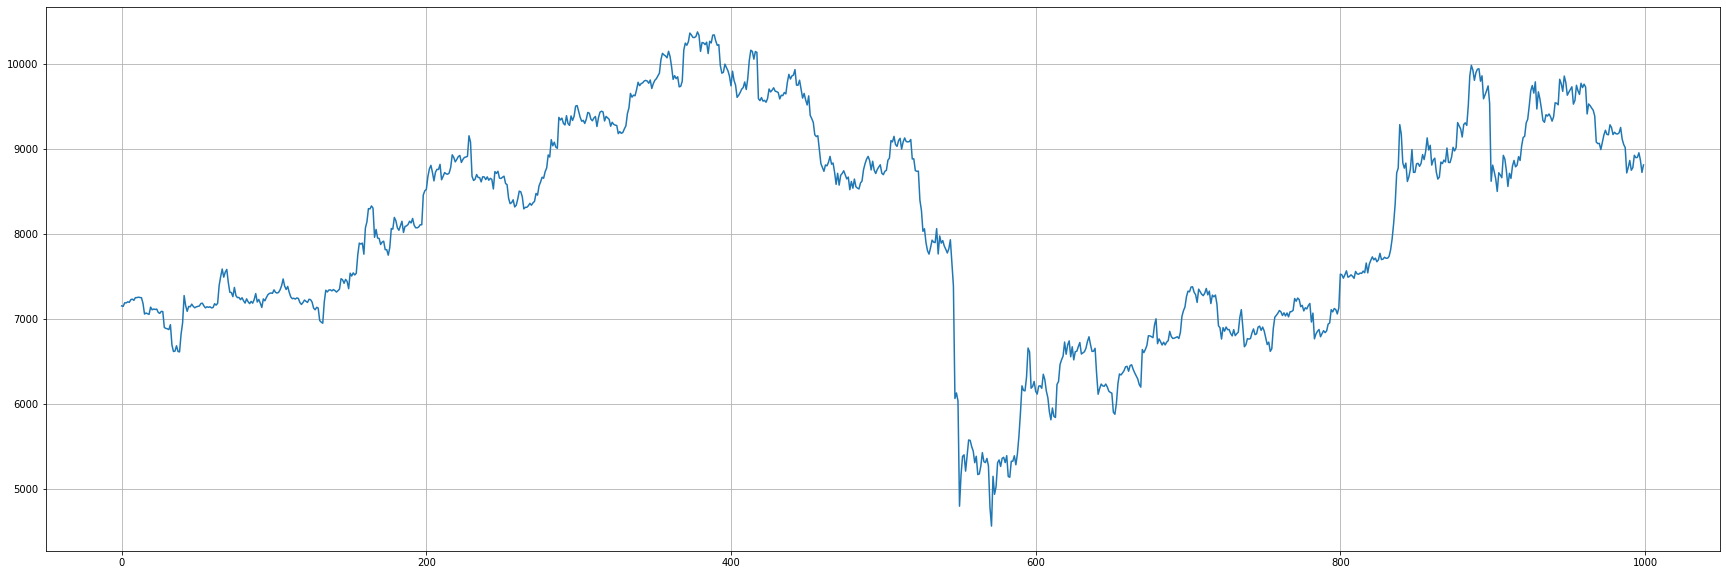

In [9]:
df['close'].plot(figsize=(30,10))
plt.grid()

In [10]:
df

,open_time,open,high,low,close,volume,close_time,quote,trades,takers_buy_base,takers_buy_quote
0,1.576109e+12,7210.00,7295.00,7080.30,7156.03,12148.135451,2019-12-12 04:59:59.999000+01:00,8.710472e+07,82652.0,5780.743496,4.146944e+07
1,1.576123e+12,7156.05,7177.46,7140.00,7151.05,3112.787743,2019-12-12 08:59:59.999000+01:00,2.228609e+07,31566.0,1580.708204,1.131707e+07
2,1.576138e+12,7150.36,7217.99,7115.00,7192.93,7863.483296,2019-12-12 12:59:59.999000+01:00,5.632209e+07,55039.0,3803.978097,2.724919e+07
3,1.576152e+12,7192.93,7222.15,7140.00,7191.56,8917.825176,2019-12-12 16:59:59.999000+01:00,6.405111e+07,63610.0,4580.256032,3.290687e+07
4,1.576166e+12,7190.98,7226.79,7175.96,7204.73,5823.075178,2019-12-12 20:59:59.999000+01:00,4.195005e+07,51653.0,2873.734963,2.070282e+07
...,...,...,...,...,...,...,...,...,...,...,...
995,1.590451e+12,8900.35,8930.00,8822.74,8903.76,7216.472004,2020-05-26 05:59:59.999000+02:00,6.412047e+07,91809.0,3351.158290,2.977792e+07
996,1.590466e+12,8903.75,8965.00,8860.05,8957.49,9398.123508,2020-05-26 09:59:59.999000+02:00,8.381308e+07,107328.0,5079.676386,4.531938e+07
997,1.590480e+12,8956.83,9017.67,8832.38,8869.15,12352.958130,2020-05-26 13:59:59.999000+02:00,1.101568e+08,130988.0,5648.478037,5.038585e+07
998,1.590494e+12,8869.32,8914.56,8705.00,8726.60,13580.857265,2020-05-26 17:59:59.999000+02:00,1.196177e+08,143663.0,6285.010666,5.538213e+07


### Generate MA

### Label candles in and out
Buy shortMA > longMA

Sell longMA > ahortMA

In [11]:
def buy_sell_sl(df, short_term_col='MA_short', long_term_col='MA_long', qty_btc=0, qty_pair=1000, price_col='close',
                time_col='close_time', sl=2, low_col='low'):
    wallet_df = pd.DataFrame(index=df.index)

    flag = -1
    trades = 0

    wallet_df[price_col] = np.nan
    wallet_df['stop_loss'] = np.nan
    wallet_df['qty_btc'] = qty_btc
    wallet_df['qty_pair'] = qty_pair  # wallet initial money i. e. usdt
    wallet_df['conversion_to_btc'] = qty_btc
    wallet_df['conversion_to_pair'] = qty_pair
    wallet_df['trades'] = trades
    wallet_df['flag'] = -1

    for i in range(len(df)):

        if df[short_term_col][i] > df[long_term_col][i]:  # compra
            if flag != 1:
                trades += 1
                wallet_df.loc[i:, 'stop_loss'] = df.loc[i][price_col] * ((100 - sl) / 100)
                wallet_df.loc[i:, price_col] = df.loc[i][price_col]
                qty_btc = qty_pair / df.loc[i][price_col] * .99
                qty_pair = 0

                wallet_df.loc[i:, 'qty_btc'] = qty_btc
                wallet_df.loc[i:, 'qty_pair'] = qty_pair
                wallet_df.loc[i:, 'conversion_to_btc'] = qty_btc
                wallet_df.loc[i:, 'conversion_to_pair'] = qty_btc * df.loc[i][price_col] * .99
                wallet_df.loc[i:, 'trades'] = trades

                flag = 1
                wallet_df.loc[i:, 'flag'] = flag

            elif (flag == 1) & (df.iloc[i][low_col] <= wallet_df.iloc[i]['stop_loss']):  # salta stop_loss y vende
                    trades += 1
                    wallet_df.loc[i:, price_col] = df.loc[i][price_col]

                    qty_pair = qty_btc * df.loc[i][price_col] * .99
                    qty_btc = 0

                    wallet_df.loc[i:, 'qty_btc'] = qty_btc
                    wallet_df.loc[i:, 'qty_pair'] = qty_pair
                    wallet_df.loc[i:, 'conversion_to_btc'] = qty_pair / df.loc[i][price_col] * .99
                    wallet_df.loc[i:, 'conversion_to_pair'] = qty_pair
                    wallet_df.loc[i:, 'trades'] = trades
                    flag = 0
                    wallet_df.loc[i:, 'flag'] = flag

        elif df[short_term_col][i] < df[long_term_col][i]:  # vende
            if flag == 1:
                trades += 1
                wallet_df.loc[i:, price_col] = df.loc[i][price_col]

                qty_pair = qty_btc * df.loc[i][price_col] * .99
                qty_btc = 0

                wallet_df.loc[i:, 'qty_btc'] = qty_btc
                wallet_df.loc[i:, 'qty_pair'] = qty_pair
                wallet_df.loc[i:, 'conversion_to_btc'] = qty_pair / df.loc[i][price_col] * .99
                wallet_df.loc[i:, 'conversion_to_pair'] = qty_pair
                wallet_df.loc[i:, 'trades'] = trades

                flag = 0
                wallet_df.loc[i:, 'flag'] = flag


    benefit = wallet_df.loc[len(df) - 1]['conversion_to_pair'] - wallet_df.loc[0]['conversion_to_pair']

    timedelta = df.iloc[-1][time_col] - df.iloc[0][time_col]
    total_hours = timedelta.total_seconds() / 60 / 60
    benefit_by_hour = benefit / total_hours

    # trades_benefit = benefit*trades
    return wallet_df, benefit, benefit_by_hour, trades

## Iterate all combos

In [12]:
import itertools

In [13]:
short_terms = range(1,200)
long_terms = range(2,200)

In [14]:
combos = list(itertools.product(*[short_terms,long_terms]))

In [15]:
def generate_short_long_combos(short,long):
    result = []
    combos = list(itertools.product(*[short,long]))
    for c in combos:
        if c[0]<c[1]:
            result.append(c)
    return result

In [16]:
combos = generate_short_long_combos(short_terms,long_terms)

In [17]:
len(combos)

19701

## Get df with combo

In [18]:
from tqdm.notebook import tqdm

def calculate_combos_benefit(original_df, combos):
    
    list_combo_dfs = []
    
    for i in tqdm(combos):
        short_term_col = f'MA_{i[0]}'
        long_term_col = f'MA_{i[1]}'

        combo_df = original_df.copy()
        combo_df[short_term_col] = combo_df['close'].rolling(i[0]).mean()
        combo_df[long_term_col] = combo_df['close'].rolling(i[1]).mean()

        _ , benefit, ben_tim, per_trades = buy_sell_sl(combo_df, short_term_col=short_term_col, long_term_col=long_term_col, qty_btc=0, qty_pair=1000, price_col='close', time_col='close_time')

        list_combo_dfs.append([i[0] ,i[1] ,benefit, ben_tim, per_trades])
        
    return list_combo_dfs

In [19]:
results = calculate_combos_benefit(original_df, combos)


In [20]:
result_df = pd.DataFrame.from_records(results, columns=['short_ma', 'long_ma', 'benefit', 'benefit_hour', 'trades'])

In [21]:
#short_, long_ = zip(*result_df[0].tolist())
#result_df['short_interval'] = np.array(short_)
#result_df['long_interval'] = np.array(long_)

In [22]:
result_df

,short_ma,long_ma,benefit,benefit_hour,trades
0,1,2,-995.161529,-0.248790,547
1,1,3,-982.104710,-0.245526,401
2,1,4,-951.962093,-0.237991,336
3,1,5,-902.336150,-0.225584,278
4,1,6,-895.381840,-0.223845,254
...,...,...,...,...,...
19696,196,198,-173.357786,-0.043339,11
19697,196,199,-218.513464,-0.054628,15
19698,197,198,-173.357786,-0.043339,11
19699,197,199,-218.513464,-0.054628,15


## Ploteamos el rendimiento de las combinaciones

In [23]:
perfect_combo = result_df.loc[result_df['benefit'].idxmax()].values

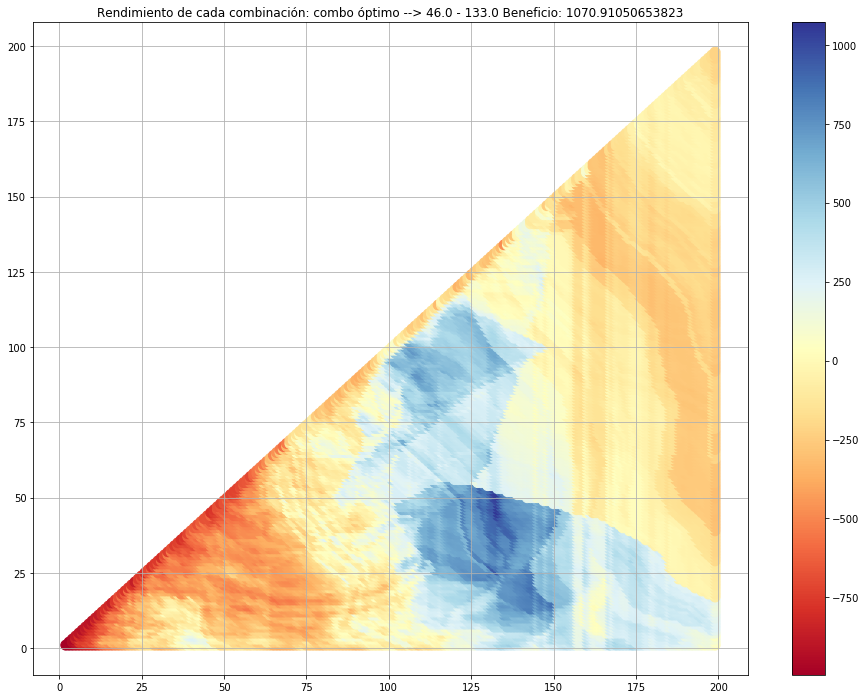

In [24]:
plt.figure(figsize=(16, 12))
color_map = plt.cm.get_cmap('RdYlBu')

plt.scatter(result_df['long_ma'], result_df['short_ma'], c=result_df['benefit'], vmin=result_df['benefit'].min(), 
            vmax=result_df['benefit'].max() , s=100, cmap=color_map)

plt.title(f'Rendimiento de cada combinación: combo óptimo --> {perfect_combo[0]} - {perfect_combo[1]} Beneficio: {perfect_combo[2]}')
plt.grid()
plt.colorbar()
plt.show()

## Numero de operaciones de cada estrategia

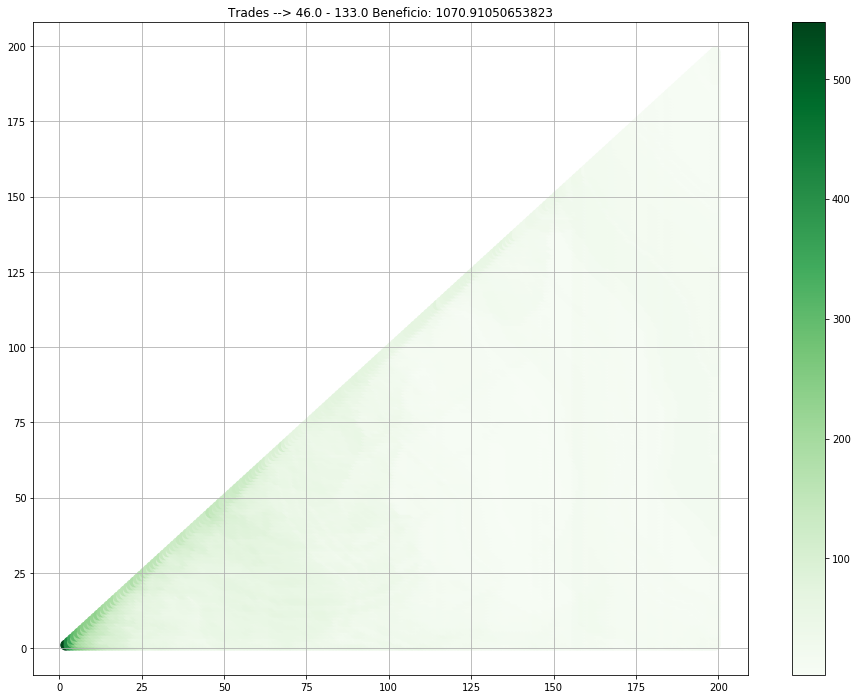

In [25]:
plt.figure(figsize=(16, 12))
color_map = plt.cm.get_cmap('Greens')

plt.scatter(result_df['long_ma'], result_df['short_ma'], c=result_df['trades'], vmin=result_df['trades'].min(), 
            vmax=result_df['trades'].max() , s=100, cmap=color_map)

plt.title(f'Trades --> {perfect_combo[0]} - {perfect_combo[1]} Beneficio: {perfect_combo[2]}')

plt.grid()
plt.colorbar()
plt.show()

### Obtenemos el punto optimo

In [26]:
result_df['benefit'].idxmax()

8006

In [27]:
result_df.loc[result_df['benefit'].idxmax()]

short_ma          46.000000
long_ma          133.000000
benefit         1070.910507
benefit_hour       0.267728
trades             4.000000
Name: 8006, dtype: float64

In [28]:
optimum_combo = result_df.loc[result_df['benefit'].idxmax()]

In [29]:
optimum_combo

short_ma          46.000000
long_ma          133.000000
benefit         1070.910507
benefit_hour       0.267728
trades             4.000000
Name: 8006, dtype: float64

## Check Optimum

In [30]:
# 39, 104  para 4 horas
# 24, 87 para 4h unos dias despues
# 45 165 para 5 minutos 15 dolares
# 46 106 para 15 minutos

In [31]:
def get_benefit_from_combo(combo_df, short, long):
    
    short_term_col = f'MA_{short}'
    long_term_col = f'MA_{long}'

    combo_df = original_df.copy()
    combo_df[short_term_col] = combo_df['close'].rolling(short).mean()
    combo_df[long_term_col] = combo_df['close'].rolling(long).mean()

    result_df , benefit, ben_tim, per_trades = buy_sell_sl(combo_df, short_term_col=short_term_col, long_term_col=long_term_col, qty_btc=0, qty_pair=1000)

    return result_df, combo_df

In [32]:
optimun_df, combo_df = get_benefit_from_combo(original_df, int(optimum_combo[0]), int(optimum_combo[1]))

In [33]:
optimun_df

,close,stop_loss,qty_btc,qty_pair,conversion_to_btc,conversion_to_pair,trades,flag
0,NaN,NaN,0.000000,1000.000000,0.000000,1000.000000,0,-1
1,NaN,NaN,0.000000,1000.000000,0.000000,1000.000000,0,-1
2,NaN,NaN,0.000000,1000.000000,0.000000,1000.000000,0,-1
3,NaN,NaN,0.000000,1000.000000,0.000000,1000.000000,0,-1
4,NaN,NaN,0.000000,1000.000000,0.000000,1000.000000,0,-1
...,...,...,...,...,...,...,...,...
995,5905.29,5787.1842,0.233528,0.000000,0.233528,1365.262714,3,1
996,8957.49,5787.1842,0.000000,2070.910507,0.228881,2070.910507,4,0
997,8957.49,5787.1842,0.000000,2070.910507,0.228881,2070.910507,4,0
998,8957.49,5787.1842,0.000000,2070.910507,0.228881,2070.910507,4,0


In [34]:
combo_df

,open_time,open,high,low,close,volume,close_time,quote,trades,takers_buy_base,takers_buy_quote,MA_46,MA_133
0,1.576109e+12,7210.00,7295.00,7080.30,7156.03,12148.135451,2019-12-12 04:59:59.999000+01:00,8.710472e+07,82652.0,5780.743496,4.146944e+07,NaN,NaN
1,1.576123e+12,7156.05,7177.46,7140.00,7151.05,3112.787743,2019-12-12 08:59:59.999000+01:00,2.228609e+07,31566.0,1580.708204,1.131707e+07,NaN,NaN
2,1.576138e+12,7150.36,7217.99,7115.00,7192.93,7863.483296,2019-12-12 12:59:59.999000+01:00,5.632209e+07,55039.0,3803.978097,2.724919e+07,NaN,NaN
3,1.576152e+12,7192.93,7222.15,7140.00,7191.56,8917.825176,2019-12-12 16:59:59.999000+01:00,6.405111e+07,63610.0,4580.256032,3.290687e+07,NaN,NaN
4,1.576166e+12,7190.98,7226.79,7175.96,7204.73,5823.075178,2019-12-12 20:59:59.999000+01:00,4.195005e+07,51653.0,2873.734963,2.070282e+07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.590451e+12,8900.35,8930.00,8822.74,8903.76,7216.472004,2020-05-26 05:59:59.999000+02:00,6.412047e+07,91809.0,3351.158290,2.977792e+07,9275.273696,9263.283308
996,1.590466e+12,8903.75,8965.00,8860.05,8957.49,9398.123508,2020-05-26 09:59:59.999000+02:00,8.381308e+07,107328.0,5079.676386,4.531938e+07,9259.763478,9264.987444
997,1.590480e+12,8956.83,9017.67,8832.38,8869.15,12352.958130,2020-05-26 13:59:59.999000+02:00,1.101568e+08,130988.0,5648.478037,5.038585e+07,9241.664565,9266.647143
998,1.590494e+12,8869.32,8914.56,8705.00,8726.60,13580.857265,2020-05-26 17:59:59.999000+02:00,1.196177e+08,143663.0,6285.010666,5.538213e+07,9219.766087,9267.054962


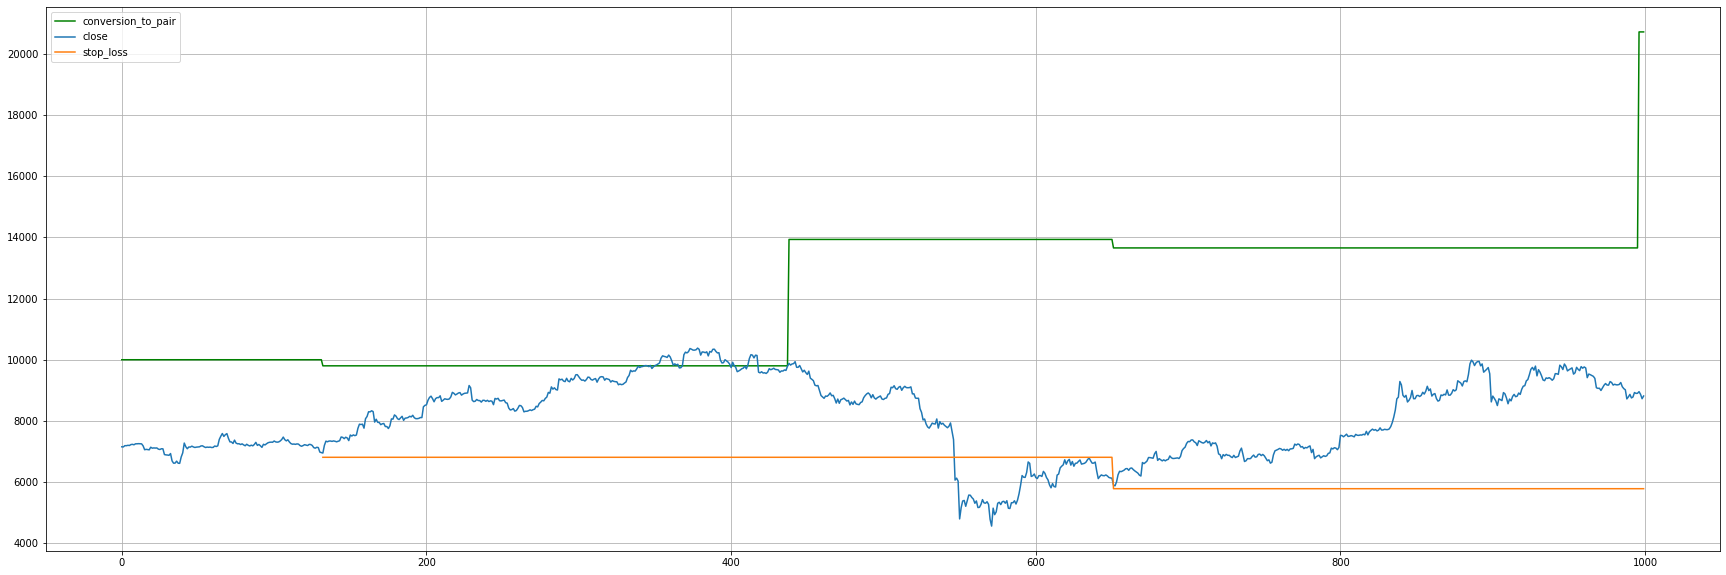

In [35]:
(optimun_df['conversion_to_pair']*10).plot(figsize=(30,10), color='green')
combo_df['close'].plot()
optimun_df['stop_loss'].plot()

plt.legend()
plt.grid()

In [36]:
optimum_combo = optimum_combo.tolist()

In [37]:
optimum_combo

[46.0, 133.0, 1070.91050653823, 0.2677276266345575, 4.0]

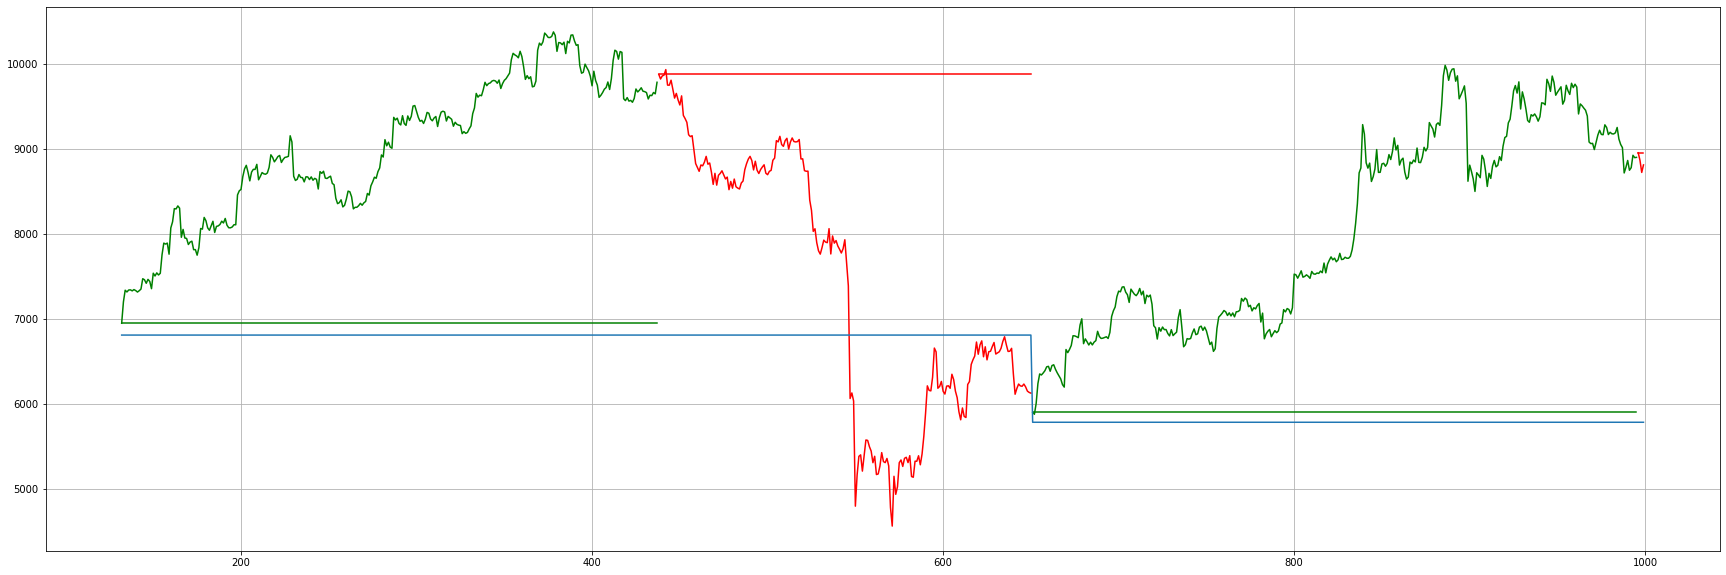

In [38]:
short, long, benefit, benefit_hour, trades = optimum_combo

short_term_col = f'MA_{int(short)}'
long_term_col = f'MA_{int(long)}'

optimun_df.where(optimun_df['flag']==1)['close'].plot(figsize=(30,10), color='green')
optimun_df.where(optimun_df['flag']==0)['close'].plot(figsize=(30,10), color='red')

combo_df.where(combo_df[short_term_col]>combo_df[long_term_col])['close'].plot(figsize=(30,10), color='green')
combo_df.where(combo_df[short_term_col]<combo_df[long_term_col])['close'].plot(figsize=(30,10), color='red')
optimun_df['stop_loss'].plot()

plt.grid()